In [1]:
# Kütüphâneleri ekleme:
import numpy as nm
import pandas as pa
import matplotlib.pyplot as plotter
from keras.models import Sequential
from keras.utils import to_categorical# Tek nokta vektörleyicisi
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.datasets import mnist
from sklearn.metrics import classification_report# Sınıflandırma sonucunu daha iyi görmek için
import warnings# Uyarıları idâre etmek için

warnings.filterwarnings("ignore")# Uyarıları kapatıyoruz

C:\Users\Yazılım alanı\AppData\Local\Temp\ipykernel_3032\18257888.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pa


In [2]:
# Veri yükleme
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

Toplam eğitim verisi sayısı: 60000
Toplam test verisi sayısı: 10000


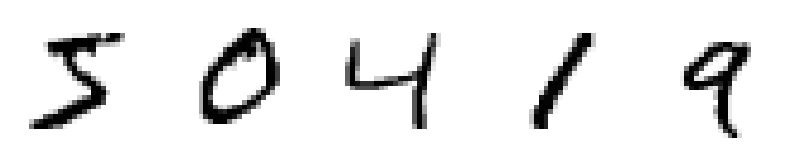

En yüksek renk kodu: 255


In [3]:
# Veri inceleme:
# Genellikle ilk boyut, veri sayısını (veyâ batch içindeki veri sayısını) ifâde eder
print(f"Toplam eğitim verisi sayısı: {xTrain.shape[0]}")
print(f"Toplam test verisi sayısı: {xTest.shape[0]}")
n = 5
fig, axes = plotter.subplots(1, n, figsize=(10, 15))
for i in range(0, n):
    axes[i].imshow(xTrain[i], cmap='binary')
    axes[i].axis('off')
plotter.show()

maxColorCode = xTrain.max()
print(f"En yüksek renk kodu: {maxColorCode}")
# maxColorCode = 255, yanî renk 8 bit kodlama ile kodlanmış

In [4]:
# Veri normalizasyonu:
# Veri tipi kontrolü:
print("Veri tipi: ", xTrain.dtype)
# Verilerimiz işâretsiz tamsayı; bu sebeple verileri normalize etmeden evvel
# 'float' tipine çevirmeliyiz:
xTrain = xTrain.astype('float32') / maxColorCode
xTest = xTest.astype('float32') / maxColorCode

Veri tipi:  uint8


In [5]:
# Kimi modeller için etiket verisi üzerinde yapmamız gereken işlem yoktur;
# fakat sinir ağları, etiket verilerindeki sınıf numaralarını birer
# büyüklük gibi değerlendirebileceğinden model menfî olarak etkilenebilir
# Bu sebeple etiket verilerini tek nokta vektörü biçiminde kodlamalıyız:
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)

print(f"yTrain[0]: {yTrain[0]}")# yTrain[0]:5

yTrain[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
# Sinir ağındaki Conv2D katmanı şu biçimde girdi bekliyor:
# (batchSize, height, width, channels)
# Bizim verimiz ise şu formatta : (adet(allBatch), height, width)
# görüntümüzün tek kanal olduğunu belirtmeliyiz:
xTrain = nm.expand_dims(xTrain, axis=3)
xTest = nm.expand_dims(xTest, axis=3)

In [7]:
# Model eğitilirken, modelin ezberleme oranını ölçmek için doğrulama
# veri seti kullanabiliriz.
# Bunun için test veri setinden biraz alalım, zâten yeterince var:
xValid, yValid = xTest[:2000], yTest[:2000]
xTest, yTest = xTest[2000:], yTest[2000:]

In [8]:
# Sinir ağı modeli hâzırlama:

# Resim verileri matris formundadır; veyâ matris formundaki katmanlardan oluşmaktadır
# Sinir ağı bunları bu hâlde işleyemez
# Verileri düzleştirmemiz, tek boyutlu yapmamız gerekiyor
# fakat bu durumda, pek çok 'komşular arası ilişki' kaybolur
# Bu sebeple konvolüsyonel sinir ağı kullanılmalıdır:
model = Sequential()
model.add(Conv2D(48, (3, 3), padding='same', activation='relu', input_shape=xTrain.shape[1:]))
model.add(Conv2D(24, (3, 3), activation='relu'))
model.add(MaxPooling2D())
# MaxPooling2D ile filtrenin gezdirildiği bölgedeki en büyük değere sâhip
# piksel alınır; bu işlem sonucunda, bir bölgedeki en önemli piksel o
# bölgeyi temsil etmiş gibi olur

model.add(Dropout(rate=0.2))
# Bağlantıların bir kısmı kapatılarak, ezberlemenin önüne geçilebilir
# Konvolüsyonel sinir ağlarında bu, sıklıkla kullanılır;
# çünkü öznitelik seçimini ağ kendisi yapmaktadır ve biz
# hangi düşük öneme sâhip özniteliğin ağı yormasını istemiyoruz.
# Yukarıdaki satıra göre, bağlantıların %20'si kapatılır.
# Model değerlendirildikten sonra burası değiştirilebilir

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.15))

# Verileri sinir ağına vermeden evvel düzleştirmeliyiz:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# 'relu' hesaplanması kolay ve gradyan azalmasına karşı dirençli olduğundan
# aktivasyon fonksiyonu olarak sıklıkla tercih edilir.
model.add(Dropout(0.10))
model.add(Dense(10, activation='softmax'))
# Son katmandaki hücre sayısı sınıf sayısına eşit olmak zorunda
# Çok sınıflı sınıflandırma problemlerinde 'softmax' kullanılmalı

model.summary()# Model özeti

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 48)          │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 24)          │          10,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           6,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          51,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,058 (293.20 KB)

 Trainable params: 75,058 (293.20 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Modelin derlenmesi:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Modelin eğitilmesi:
# Ezberleme fark edildiğinde modelin durması için erken durdurma çağrısı eklenmeli:
callEarlyStopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
model.fit(xTrain, yTrain,
          batch_size = 1024, epochs = 10,
          callbacks = [callEarlyStopping],
          validation_data = (xValid, yValid))

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 343s 6s/step - accuracy: 0.4935 - loss: 1.4783 - val_accuracy: 0.9420 - val_loss: 0.1936
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.9430 - loss: 0.1844 - val_accuracy: 0.9700 - val_loss: 0.0998
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - accuracy: 0.9645 - loss: 0.1156 - val_accuracy: 0.9760 - val_loss: 0.0796
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 329s 6s/step - accuracy: 0.9729 - loss: 0.0891 - val_accuracy: 0.9825 - val_loss: 0.0567
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.9766 - loss: 0.0743 - val_accuracy: 0.9845 - val_loss: 0.0476
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.9799 - loss: 0.0641 - val_accuracy: 0.9865 - val_loss: 0.0416
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.9833 - loss: 0.0561 - val_accuracy: 0.9850 - val_loss: 0.0366
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9835 - loss: 0.0524 - val_accuracy: 0.9875 - v

In [11]:
# Başarı oldukça yüksek, fakat kurulan güzel mimârinin de etkisiyle ezberlemenin önüne geçilmiş gibi duruyor
# Daha yakından bakmak için eğitim geçmişini almalıyız:
history = model.history.history

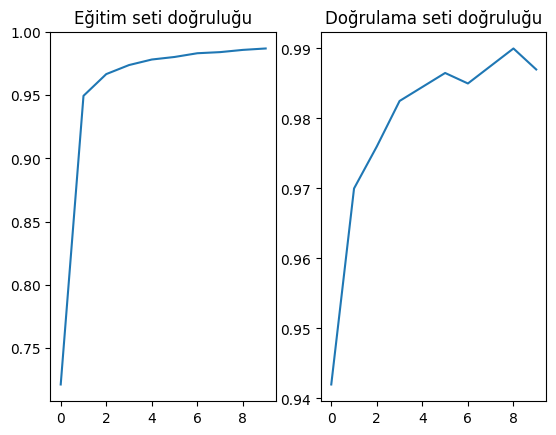

In [21]:
fig, axes = plotter.subplots(1,2)
axes[0].plot(history['accuracy'])
axes[0].set_title('Eğitim seti doğruluğu')
axes[1].set_title('Doğrulama seti doğruluğu')
axes[1].plot(history['val_accuracy'])
plotter.show()

In [22]:
# Şimdi modeli test veri setinde test ederek sonuçtan emîn olmaya çalışalım, inşâAllâh:
predicts = model.evaluate(xTest, yTest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.8877e-04


In [29]:
o = model.predict(xTest[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


In [37]:
_, accuracy = model.evaluate(xTest, yTest)

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9868 - loss: 0.0358


In [41]:
print(f"Model doğruluk oranı:{nm.round(accuracy, 4)}")

Model doğruluk oranı:0.9924


In [55]:
# 8000 veri için %0.0076 hatâ varsa 8000*0.0076'dan yaklaşık 60 - 61 adet hatâlı tespit var demektir.
# Bu hatâlı tespitler de kuvvetle muhtemel birbirine çok benzer harflerdir.
# Bu hatâlı tespitleri öğrenmek için;
preds = model.predict(xTest).argmax(axis=1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step


In [87]:
# Hangi indisli elemanları yanlış tespit ettiğimizi bulmak için;
indicesThatWrong = nm.where(preds != yTest.argmax(axis=1))[0]

In [89]:
print(f"Hatâlı tespit edilen örnek sayısı: {indicesThatWrong.shape[0]}")
print(f"Hatâlı tespit edilenlerin indisleri: {indicesThatWrong}")

Hatâlı tespit edilen örnek sayısı: 61
Hatâlı tespit edilenlerin indisleri: [  18   35   43  109  118  129  130  135  369  387  414  447  462  597
  654  896  927  939  959 1073 1289 1422 1520 1534 1558 1626 1726 1767
 1808 1941 2078 2176 2207 2224 2238 2284 2497 2639 2740 2761 2807 2814
 2860 2956 3937 4555 4559 4571 4572 4576 4597 4651 4783 6316 6520 7009
 7530 7679 7692 7729 7792]


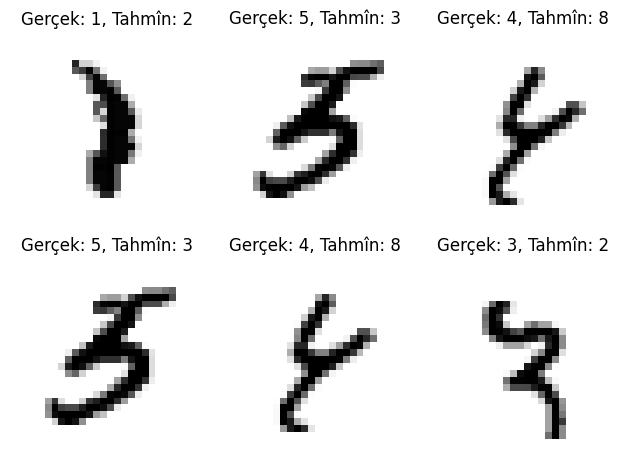

In [105]:
# 6 hatâlı tespite bakmak istersek;
fig, axes = plotter.subplots(2,3)
for i in range(2):
    for j in range(3):
        axes[i][j].imshow(xTest[indicesThatWrong[i + j]].squeeze(), cmap='binary')
        axes[i][j].set_title(f"Gerçek: {yTest[indicesThatWrong[i + j]].argmax()}, Tahmîn: {preds[indicesThatWrong[i + j]]}")
        axes[i][j].axis('off')
plotter.tight_layout()
plotter.show()
# Eğer matplotlib'e (28, 28, 1) boyutunda bir dizi verirseniz bunu çizemez.
# squeeze() metodu, tek elemanlı eksenleri kaldırır; yanî veriyi (28, 28) boyutuna getirir.
# Bunu reshape() metoduyla da yapabilirsiniz;
# fakat bu işlemi squeeze() ile yapmak daha hatâdan uzak bir yoldur.

- Gerçekten bu rakamlar aslî hüviyetinden çook uzak; modelin buradaki hatâsı anlamlı değil

- Yazar : Mehmet Akif SOLAK